# CMAPSS using Deep Neural Networks - Classification
This notebook contains a minimal example of DNN for the CMAPSS datasets based on a _classification_ approach, including
1. Updated and refactored data preprocessing scripts
2. NN architecture and training steps

```
Author: CSN
Last modified: 20221102
```

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
# Import all relevant libraries
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from utils.utils import (clean_test_dataf, clean_train_dataf, encode_rul,
                         lag_dataframe, scale_test_dataf, scale_train_dataf)

In [2]:
filename = './data/train_FD001.tar.gz'

# Set the column names for the raw CMAPSS data
columns = ['machine_number', 'uptime', 'setting_1', 'setting_2', 'setting_3']
sensor_measurements = [f'sensor_{i:02d}' for i in range(1, 25)]
columns += sensor_measurements

# Read plain text file
df = pd.read_csv(filename, sep=" ", names=columns, index_col=False)

# Drop dummy columns
df.drop(columns=['sensor_22', 'sensor_23', 'sensor_24'], inplace=True)

In [3]:
# # Supplementary cell to write data for PCS-CMAPSS
# def add_train_RUL(grp):
#     # Apply clipping to RUL based on uptime
#     grp['RUL'] = (grp['uptime'].max() - grp['uptime'] + 1)
#     # Apply clipping to RUL
#     grp['RUL'].clip(upper=125, inplace=True)
# 
#     return grp
# 
# # Verify the number of columns in the training df
# (df
#   .sort_values(by=['machine_number', 'uptime'], axis=0)
#   .groupby('machine_number', group_keys=True)
#   .apply(add_train_RUL)
# ).to_csv('./data/train_FD001.csv', index=False)
# pd.read_csv('./data/train_FD001.csv').shape

In [4]:
# Use the profiler to remove constant values
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df)
# profile.to_file("FD001.html")

Next we load or recomputed the rejected features. This list of rejected features is quite well known throughout literature. The main reasons why they are selected is because they contain constants, whereas other features contain some form of trends.

In [5]:
rejected_feature_fname = './data/rejected_features.txt'
if os.path.exists(rejected_feature_fname):
    # Check if has feature selection has been done and load the file
    with open(rejected_feature_fname, 'r') as f:
        rejected_features = f.read().splitlines()
else:
    # Get list of rejected variables due to constant values
    rejected_features = list(profile.get_rejected_variables())
    # Remove sensor_06 which is also constant. Comes from viewing the data.
    rejected_features += ['setting_1', 'setting_2', 'sensor_06']
    # Write to file
    with open(rejected_feature_fname, 'w') as f:
        for feature in rejected_features:
            f.write(f"{feature}\n")

Now we load the test datasets for the final scoring.

In [6]:
# Now load the test set and apply the same preprocessing
df_test = pd.read_csv('./data/test_FD001.tar.gz', sep=" ", names=columns, index_col=False)

# Drop dummy columns
df_test.drop(columns=['sensor_22', 'sensor_23', 'sensor_24'], inplace=True)

# Load the y_test
y_test = pd.read_csv('./data/RUL_FD001.tar.gz', names=['RUL'])
y_test['machine_number'] = y_test.index + 1

# Join the test X and label dataframes
df_test = df_test.join(y_test.set_index('machine_number'), on='machine_number')

In [7]:
# # Supplementary cell to write data for PCS-CMAPSS demo
# def add_test_RUL(grp):
#     grp['RUL'] += grp['uptime'].max() - grp['uptime']
#     # Apply clipping to RUL
#     grp['RUL'].clip(upper=125, inplace=True)
#     return grp
# 
# # Verify the number of columsn in the test set
# (df_test
#   .sort_values(['machine_number', 'uptime'], axis=0)
#   .groupby('machine_number', group_keys=True)
#   .apply(add_test_RUL)
# ).to_csv('./data/test_FD001.csv', index=False)
# pd.read_csv('./data/test_FD001.csv').shape

In the next cell we preprocess all the data using the `pandas` pipeline functionality.

In [8]:
num_lags = 30

# Run pre-processing on train set with encoded RUL
clean_df = (df
            .pipe(clean_train_dataf, rejected_features=rejected_features)
            .pipe(encode_rul)
            .drop(columns=['uptime'])
            )
# Split this pipe step to store scaler for later reuse
clean_df, scaler = clean_df.pipe(scale_train_dataf)
clean_df = clean_df.pipe(lag_dataframe, num_lags=num_lags)

# Run pre-processing on test set with encoded RUL
# clean_df_test = (df_test
#                  .pipe(clean_test_dataf, rejected_features=rejected_features)
#                  .drop(columns=['uptime'])
#                 )
# clean_df_test = (clean_df_test.pipe(encode_rul))
clean_df_test = (df_test
                 .pipe(clean_test_dataf, rejected_features=rejected_features)
                 .pipe(encode_rul)
                 .drop(columns=['uptime'])
                )
clean_df_test = clean_df_test.pipe(scale_test_dataf, scaler=scaler)
clean_df_test = clean_df_test.pipe(lag_dataframe, num_lags=num_lags)

# Run pre-processing on test set with encoded RUL
clean_df_test_org = (df_test
                 .pipe(clean_test_dataf, rejected_features=rejected_features)
                 .drop(columns=['uptime'])
                )
clean_df_test_org = clean_df_test_org.pipe(scale_test_dataf, scaler=scaler)
clean_df_test_org = clean_df_test_org.pipe(lag_dataframe, num_lags=num_lags)
y_test_org = clean_df_test_org.pop('RUL').astype(float)

Now we construct our train, test, and validation sets.

In [9]:
# Preview the encoded and original y_test values to make sure they make sense
random_seed = 42
print(y_test.sample(10, random_state=random_seed))
print(y_test_org.sample(10, random_state=random_seed))

    RUL  machine_number
83   58              84
53   97              54
70  118              71
45   47              46
44  114              45
39   28              40
22  113              23
80    8              81
10   97              11
0   112               1
29     125.0
15     113.0
95     105.0
79     113.0
25     125.0
116     24.0
83      82.0
105    125.0
111    125.0
5      125.0
Name: RUL, dtype: float64


In [10]:
x_train = clean_df.copy()
# x_train = clean_df[(clean_df['machine_number'] >= 1) & (clean_df['machine_number'] <= 50)].copy()
y_train = x_train.pop('RUL').astype(float)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)

x_test = clean_df_test.copy()
# x_test = clean_df_test[(clean_df_test['machine_number'] >= 1) & (clean_df_test['machine_number'] <= 50)].copy()
y_test = x_test.pop('RUL').astype(float)

# y_test_org = clean_df_test_org.pop('RUL').astype(float)

if False:
    x_train.to_parquet('./data/x_train.parquet.gzip', compression='gzip')
    x_test.to_parquet('./data/x_test.parquet.gzip', compression='gzip')
    y_train.to_csv('./data/y_train.csv', index=False)
    y_test.to_csv('./data/y_test.csv', index=False)

# Drop 'machine_number' from the train/test
x_train_id = x_train.pop('machine_number')
x_test_id = x_test.pop('machine_number')

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# # Reserve 20% samples for validation
# val_rows = int(0.2*len(x_train))
# x_val = x_train.iloc[-val_rows:]
# y_val = y_train.iloc[-val_rows:]
# x_train = x_train.iloc[:-val_rows]
# y_train = y_train.iloc[:-val_rows]

# Training and evaluation
This section contains a basic MLP model and training procedure

In [11]:
def root_mean_squared_error(y_true, y_pred):
    # Define an rms loss function
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def scheduler(epoch, lr):
    # Define a custom scheduler to vary learning rate based on epoch
    # Based on: https://doi.org/10.1016/j.ress.2017.11.021, page 5
    if epoch < 100:
      return lr
    else:
      lr = 1e-4
      return lr

In [12]:
# Create the model using the functional API approach
num_features = x_train.shape[1]
inputs = keras.Input(shape=(num_features,))
x = layers.Dense(800, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(700, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="classification_model")

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics='accuracy'
)

2022-10-27 17:18:58.339500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Create callback for scheduling learning rate
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(
    x=x_train,
    y=y_train,
    epochs=20,
    # Suppress logging.
    # verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[callback],)

Epoch 1/20
441/441 [==============================] - 3s 6ms/step - loss: 0.4092 - accuracy: 0.8231 - val_loss: 0.3163 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 2/20
441/441 [==============================] - 2s 5ms/step - loss: 0.3421 - accuracy: 0.8536 - val_loss: 0.3008 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 3/20
441/441 [==============================] - 2s 5ms/step - loss: 0.3197 - accuracy: 0.8628 - val_loss: 0.2838 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/20
441/441 [==============================] - 2s 5ms/step - loss: 0.3130 - accuracy: 0.8646 - val_loss: 0.2969 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 5/20
441/441 [==============================] - 2s 5ms/step - loss: 0.3020 - accuracy: 0.8708 - val_loss: 0.2874 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 6/20
441/441 [==============================] - 2s 5ms/step - loss: 0.2891 - accuracy: 0.8735 - val_loss: 0.2843 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 7/20
441/441 [==============================] - 2s 5ms/step - lo

In [14]:
def plot_loss(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(history.history['loss'], label='train_loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[1].plot(history.history['accuracy'], label='train_acc')
    axs[1].plot(history.history['val_accuracy'], label='val_acc')
    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True)
    axs[0].set_ylabel('RUL')
    axs[1].set_ylabel('Acc RUL')

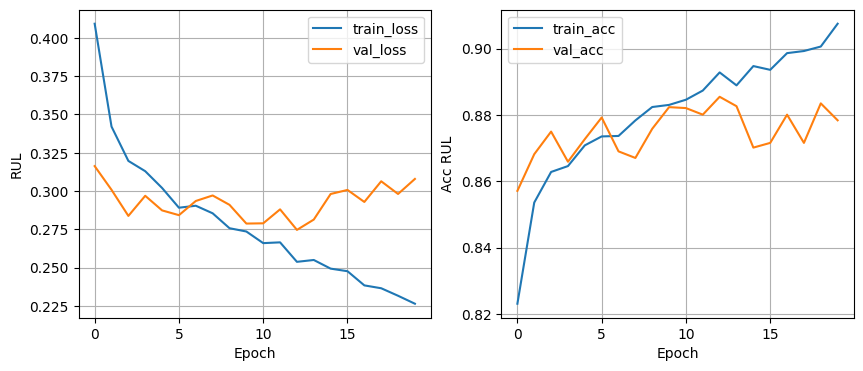

In [15]:
plot_loss(history)
plt.show()

# Visualise prediction on the test datasets

Here, we run a prediction on the test set, which the model has not seen before. We also visualise a subset of the predictions against the ground truth as a sanity check.

94/94 [==============================] - 0s 2ms/step


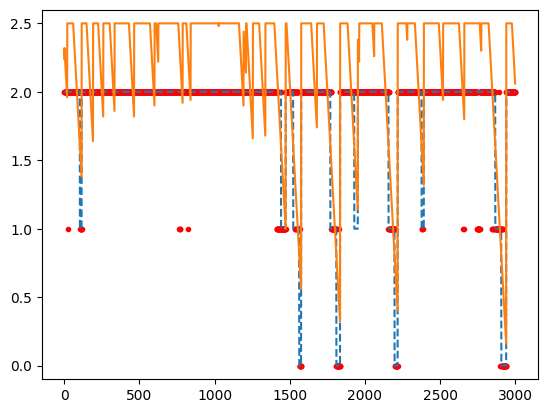

In [16]:
ind_ = 3000
y_predict = tf.argmax(input=model.predict(x_test.iloc[:ind_]), axis=1) 
plt.plot(y_predict.numpy(), 'r.')
plt.plot(y_test.iloc[:ind_].to_numpy(), '--')
plt.plot(y_test_org.iloc[:ind_].to_numpy()/125*2.5)
plt.ylim([-0.1, 2.6])
plt.show()

# Evaluate prediction on the test datasets

In [17]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
y_test_ = tf.keras.utils.to_categorical(y_test, num_classes=3)
results = model.evaluate(x_test, y_test_)
print("test loss, test accuracy:", results)
# print(f"test rmse {np.sqrt(results[1]):.4f}")

Evaluate on test data
316/316 [==============================] - 1s 2ms/step - loss: 0.2627 - accuracy: 0.9104
test loss, test accuracy: [0.2627120316028595, 0.9103605151176453]


In [18]:
print(np.sum(y_test_, axis=0))
print(np.sum(y_val, axis=0))
print(np.sum(y_train, axis=0))

[ 596. 1484. 8016.]
[ 800.  800. 1927.]
[3200. 3200. 7704.]


## Note
It is a good practice to re-train the model multiple times and evaluate the mean and standard deviation of the rmse. This is due to the randomness of the initialisations as well as the dropout rate.